No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


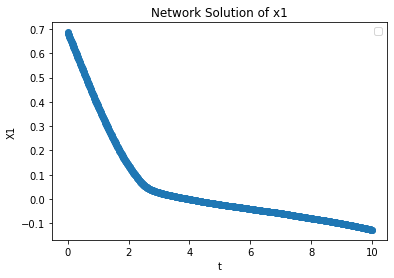

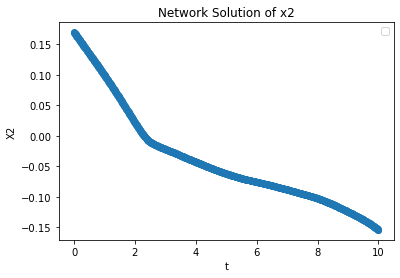

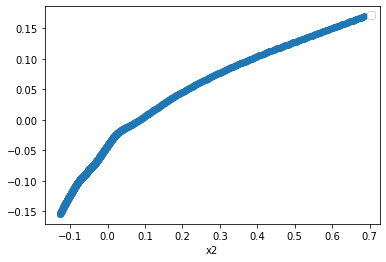

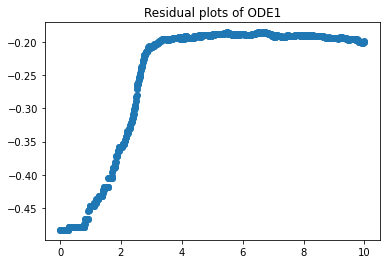

In [4]:
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np
import matplotlib.pyplot as plt


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.regressor = nn.Sequential(nn.Linear(1, 1024),
                                       nn.LeakyReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.LeakyReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.LeakyReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.LeakyReLU(inplace=True),
                                       nn.Linear(1024, 1024),
                                       nn.LeakyReLU(inplace=True),
                                       nn.Linear(1024, 2))
    def forward(self, x):
        output = self.regressor(x)
        return output


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)

LEARNING_RATE = 1e-5
MU = 1; # For Van der Pol equation
TRAIN_LIM = 10*MU
COL_RES = 500
EPOCHS = 5000

#Boundary Conditions
t_bc = np.array([[0]])
x_bc = np.array([[2,0]])

# Points and weight boundary vs ODE Loss
col_points = int(TRAIN_LIM*COL_RES)
boundary_points = len(x_bc)

F_WEIGHT = 1 #Physics Weight
B_WEIGHT = 1/(10*(boundary_points+col_points)) #Boundary Weight


#Define Net, apply to device and init weights
net = Net()
net = net.to(device)
net.apply(init_weights)


#Define Criteria
criterion = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(net.parameters(),lr = LEARNING_RATE)


#ODE Driven loss function
def f(t,mu,net):
    x = net(t) 
    x1 = x[:,0]
    x2 = x[:,1]
    ## Van der Pol Equation
    x1_t = torch.autograd.grad(x1.sum(), t, create_graph=True)[0]
    x2_t = torch.autograd.grad(x2.sum(), t, create_graph=True)[0]
    ode1 = x1_t-x2
    ode2 = mu*(1-x1**2)*x2-x1-x2_t
    return ode1,ode2

def lossCalc(mse_u,mse_f,bp,cp,f_weight,b_weight,epoch = -1,beta = 1,betaLim = 1):
    #Function to combine loss from boundary and ODE or PDE
    if epoch*beta > betaLim or epoch == -1:
        loss = (b_weight*mse_u)/bp + (f_weight*mse_f/cp)
        epochBeta = betaLim
    else:
        loss = (b_weight*mse_u)/bp + (f_weight*mse_f/cp)*epoch*beta
        epochBeta = epoch*beta
    
    return loss,epochBeta


for epoch in range(EPOCHS):
    optimizer.zero_grad() # to make the gradients zero
    
    # Loss based on boundary conditions
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    
    net_bc_out = net(pt_t_bc) # output of u(x,t)
    mse_u = criterion(input = net_bc_out, target = pt_x_bc)

    # Loss based on PDE
    t_collocation = np.random.uniform(low=0.0, high=TRAIN_LIM, size=(col_points,1))
    all_zeros = np.zeros((col_points,1))
    
    
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    ode1,ode2 = f(pt_t_collocation,MU,net) # output of f(x,t)
    mse_f = criterion(input = ode1, target = pt_all_zeros)+criterion(input = ode2, target = pt_all_zeros)
    
    # Combining the loss functions
    loss,epochBeta = lossCalc(mse_u,mse_f,boundary_points,col_points,F_WEIGHT,B_WEIGHT)
    
    loss.backward() 
    optimizer.step() 

    with torch.autograd.no_grad():
        if epoch%100 == 0:
            print('Epoch:',epoch,"Traning Loss:",loss.data,'epochBeta:',epochBeta)
            print('Boundary Loss:',mse_u/boundary_points,'ODE Loss: ',mse_f/col_points)
        

## Plot of solution within trained bounds
n = 1000
T_test = torch.linspace(0,TRAIN_LIM,n,requires_grad=True).to(device)
T_test = T_test.reshape(n,1)

score = net(T_test) 

x1_plot = score[:,0].cpu().detach().numpy()
x2_plot = score[:,1].cpu().detach().numpy()

T_plot = torch.linspace(0,TRAIN_LIM,n,requires_grad=False)
T_plot = T_test.reshape(n,1)
T_plot = T_plot.cpu().detach().numpy()

ode1_residual,ode2_residual = f(T_test,MU,net)
ode1_residual = ode1_residual[:,0].cpu().detach().numpy()
ode2_residual = ode2_residual[:,1].cpu().detach().numpy()

plt.figure()
plt.scatter(T_plot,x1_plot)
plt.title('Network Solution of x1')
plt.xlabel('t')
plt.ylabel('X1')
plt.legend()


plt.figure()
plt.scatter(T_plot,x2_plot)
plt.title('Network Solution of x2')
plt.xlabel('t')
plt.ylabel('X2')
plt.legend()


plt.figure()
plt.scatter(x1_plot,x2_plot)
plt.xlabel('x1')
plt.xlabel('x2')
plt.legend()


plt.figure()
plt.title('Residual plots of ODE1')
plt.scatter(T_plot,ode1_residual)


plt.figure()
plt.title('Residual plots of ODE2')
plt.scatter(T_plot,ode2_residual)




